# Demo Retrieving Wav Files to Tympan

In [1]:
import getFileFromTympan as tymp                # Module for managing Tympan serial ports and file transfer
import serial #pip install pyserial
from time import sleep

# Globals
#my_com_port = 'COM9'    #Look in the Arduino IDE! 
tympan_vid = 5824
get_audio_filename = 'AUDIO003.WAV'

### List Tympan Serial Ports

In [2]:
# Get list of Tympan serial ports that match the serial port's VID
available_ports = tymp.get_tympan_ports(target_vid=tympan_vid)

if (available_ports):
    print(available_ports)

else:
    print("Err: No Tympan ports found")

# Print details on all the ports
#print(tymp.get_port_info(tympan_ports))


USB Serial Device (COM9)          Teensy 


### Open Serial Port

In [3]:
#target_port = available_ports[0]
tympan_port = []                                            # Placeholder for opened tympan port

# Method for opening a tympan port
def open_serial_port(port_to_open, retries=5):
    connected_flag = False

    # Open serial port
    while ( not (connected_flag) and (retries>0) ):
        try: 
            my_port = serial.Serial(port=port_to_open.device, baudrate=115200, timeout=0.5) #baudrate doesn't matter for Tympan; wait period in sec
            
            if(my_port.is_open):
                print("Opened: ", port_to_open.device)
                connected_flag = True
        
        except serial.SerialException as e:
            print(e)
            print("Closing ", my_port.port)
            
            # close and try again
            my_port.close()
            retries-=1
            sleep(1)

    return my_port



# Check that there are available ports
if (available_ports):
    try:
        # if serial port opened previously, close it
        if 'my_port' in locals():
            tympan_port.close()

        # If port is specified, open it.
        if 'target_port' in locals():
            tympan_port = open_serial_port(target_port)
    
        # Else If only one port, open it
        elif (len(available_ports)==1):
            target_port = available_ports[0]
            tympan_port = open_serial_port(target_port)

        # Else more than one Tympan port, need to specify
        else:
            print("More than one Tympan port.  Please specify target_port")

    except Exception as e:
        print(f"{type(e).__name__} at line {e.__traceback__.tb_lineno}: {e}")

else:
     print("Err: No Tympan ports found")

Opened:  COM9


### Print Help Menu

In [4]:
if (tympan_port):
    if (tympan_port.is_open):
        reply = []
        tymp.sendTextToSerial(tympan_port, 'h')                             # Help Menu
        reply = tymp.readMultipleLinesFromSerial(tympan_port, wait_period_sec=0.5)
        if not (reply):
            print("Err: No help menu sent.")
else: 
    print("Err: no port opened")

 General: No Prefix

   h    : Print this help

   w/e/E: INPUT  : Switch to the PCB Mics, pink jacks, or digital mics

   k/K  : CHIRP  : Incr/decrease loudness of chirp (cur = 0.0 dBFS)

   d/D  : CHIRP  : Incr/decrease duration of chirp (cur = 4.0 sec)

   n    : CHIRP  : Start the chirp

   1-3  : SDPlay : Play files 1-3 from SD Card

   q    : SDPlay : Stop any currently plying SD files

   c    : AutoWrite : Start chirp and SD recording together

   4-6  : AutoWrite : Start files 1-3 from SD Card and SD recording together

   g/G  : OUTPUT : Incr/decrease DAC loudness (cur = -20.0 dB)

   r/s  : SDWrite: Manually Start/Stop recording

---------------------------------------------------

   L    : List of the files on SD card

   f    : Open the file from SD (will prompt you for filename)

   b    : Get the size of the file in bytes

   t    : Transfer the whole file from SD to Serial

   >    : SDUtil : Start MTP mode to read SD from PC

 AudioSDWriter: Prefix = _Ax

   r,s,d: SD

### Set Mic Input

In [5]:
# Switch to Digital mics
tymp.sendTextToSerial(tympan_port, 'E')                             # Digital (PDM) mics
#tymp.sendTextToSerial(tympan_port, 'W')                            # Pink mic jack with bias voltage
#tymp.sendTextToSerial(tympan_port, 'e')                            # Pink mic jack with no bias (generally not used with typical mics)
#tymp.sendTextToSerial(tympan_port, 'w')                            # PCB mics on Tympan board

reply = tymp.readMultipleLinesFromSerial(tympan_port, wait_period_sec=0.5)

SerialManagerBase: sending: STATE=BTN:configPCB:0

SerialManagerBase: sending: STATE=BTN:configMIC:0

SerialManagerBase: sending: STATE=BTN:configLINE:0

SerialManagerBase: sending: STATE=BTN:configPDM:0

SerialManagerBase: sending: STATE=BTN:configPDM:1

SerialManagerBase: sending: TEXT=BTN:inpGain:0.0



### Play a wav file from SD card

In [6]:
# Play wav file from SD card (PLAY1.WAV) and start recording to SD
tymp.sendTextToSerial(tympan_port, '1')
reply = tymp.readMultipleLinesFromSerial(tympan_port, wait_period_sec=10, end_seq = "finished.")     #assumes a short timeout of 0.5s (check 'tympan_port.timeout')
tymp.clear_buffer(tympan_port)

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD has finished.



### Play a wav file from SD and make a recording

In [7]:
# Play wav file from SD card (PLAY1.WAV) and start recording to SD
tymp.sendTextToSerial(tympan_port, '4')
reply = tymp.readMultipleLinesFromSerial(tympan_port, wait_period_sec=10, end_seq = "finished.")     #assumes a short timeout of 0.5s (check 'tympan_port.timeout')
tymp.clear_buffer(tympan_port)

AudioSDWriter: Opened AUDIO024.WAV

serviceAudioSdStartStop: Starting SD 1 playback...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD is still playing...

serviceChirpStartStop: Chirp or SD has finished.



### List files on Tympan SD card

In [8]:
# let's ask for a list of files on the Tympan's SD card
tymp.sendTextToSerial(tympan_port, 'L')                         #send the command to the Tympan
reply = tymp.readMultipleLinesFromSerial(tympan_port)           #get the one-line reply from the Tympan
print("REPLY:",reply.strip())                                   #print the line to the screen here in Python

# let's break up the full text reply into the filenames
fnames = tymp.processLineIntoFilenames(reply)                   #parse out the filenames
print("RESULT: Files on Tympan SD:", fnames)                    #print the line to the screen here in Python

REPLY: Listing Files on SD:PLAY1.WAV,PLAY2.WAV,PLAY3.WAV,PLAY4.WAV,AUDIO001.WAV,AUDIO002.WAV,AUDIO003.WAV,AUDIO004.WAV,AUDIO005.WAV,AUDIO006.WAV,AUDIO007.WAV,AUDIO008.WAV,mtpindex.dat,AUDIO009.WAV,AUDIO010.WAV,AUDIO011.WAV,AUDIO012.WAV,AUDIO013.WAV,AUDIO014.WAV,AUDIO015.WAV,AUDIO016.WAV,AUDIO017.WAV,AUDIO018.WAV,AUDIO019.WAV,AUDIO020.WAV,AUDIO021.WAV,AUDIO022.WAV,AUDIO023.WAV,AUDIO024.WAV,
RESULT: Files on Tympan SD: ['PLAY1.WAV', 'PLAY2.WAV', 'PLAY3.WAV', 'PLAY4.WAV', 'AUDIO001.WAV', 'AUDIO002.WAV', 'AUDIO003.WAV', 'AUDIO004.WAV', 'AUDIO005.WAV', 'AUDIO006.WAV', 'AUDIO007.WAV', 'AUDIO008.WAV', 'mtpindex.dat', 'AUDIO009.WAV', 'AUDIO010.WAV', 'AUDIO011.WAV', 'AUDIO012.WAV', 'AUDIO013.WAV', 'AUDIO014.WAV', 'AUDIO015.WAV', 'AUDIO016.WAV', 'AUDIO017.WAV', 'AUDIO018.WAV', 'AUDIO019.WAV', 'AUDIO020.WAV', 'AUDIO021.WAV', 'AUDIO022.WAV', 'AUDIO023.WAV', 'AUDIO024.WAV']


### Download file to the PC

In [9]:
err = []
reply = []

# Specify a name using file_to_download or leave blank to download the last file
file_to_download =  []              #'PLAY1.WAV'

if (file_to_download):
    pass
elif len(fnames) > 0:
    file_to_download = fnames[-1] #load the last (ie, the most recent?)
else:
    err = "ERR: No file specified"
    print(err)


# Prepare to open a the file on the Tympan
if not(err):
    print("ACTION: Asking for file:",file_to_download)
    tymp.sendTextToSerial(tympan_port, 'f')                   
    reply = tymp.readLineFromSerial(tympan_port)             
    print("REPLY:",reply.strip())                            

    # Check for errors
    if ("ERROR" in reply):
        err = reply


# Send the filename that we want
reply = []
if not(err):
    tymp.sendTextToSerial(tympan_port, file_to_download)     
    reply = tymp.readLineFromSerial(tympan_port)              
    print("REPLY:",reply.strip())              
    
# Check for errors
if ("ERROR" in reply):
    err = reply
    print("Err: ", reply)      


# Get the file size in bytes
reply = []
n_bytes = []
if not(err):
    tymp.sendTextToSerial(tympan_port, 'b')                   #send the command to the Tympan
    reply = tymp.readLineFromSerial(tympan_port)              #get the one-line reply from the Tympan
       
    # Check for error
    try:
        n_bytes = int(reply)                                      #interpret the value as an integer
        if (n_bytes>0):
            print("RESULT: File size (B) =", n_bytes)                           #print the value to the screen here in Python
    
    except Exception as e:
        err = e
        print("Err: Bad file size.", err)


# Transfer the file itself
if not(err):
    # Clear the buffer
    tymp.clear_buffer(tympan_port) 

    # Receive file from the Tympan
    tymp.sendTextToSerial(tympan_port, 't')                   #send the command to the Tympan
    reply = tymp.readBytesFromSerial(tympan_port,n_bytes)     
    #print("REPLY:",reply)                                     #print the bytes to the screen here in Python

    #Check for error
    try:
        if(n_bytes==len(reply)):
            print ("Successfully downloaded Bytes: ", n_bytes)
            wav_bin = reply
        else:
            err = "Err: Did not download full file size"
            print(err)
    except Exception as e:
        err = e
        print(err)

ACTION: Asking for file: AUDIO024.WAV
REPLY: SerialMonitor: Opening file: Send filename (ending with newline character) within 10 seconds
REPLY: SerialMonitor: AUDIO024.WAV successfully opened
RESULT: File size (B) = 4607020
Successfully downloaded Bytes:  4607020


### Verify WAV file

In [10]:
# Verify wav file header starts with ASCII 'RIFF' (0x52494646) and 'fmt '
if (wav_bin[0:4] == bytearray(b'RIFF')) and \
    (wav_bin[12:16] == bytearray(b'fmt ')) and \
    (wav_bin[36:40]==bytearray(b'data')):
    
    print("WAV File Verifed")      #Could you better error checking of header vs data

# Header not valid, or could be a header file of unexpected length. 
#    Should actually search for the keyword 'data' then skip 4 bytes
else: 
    err = 'ERR: Wave file header not valid, or header unexpected length'
    print(err)

WAV File Verifed


### Split WAV file into Header and Data

In [11]:
import struct
import numpy as np

# Parse header properties
wav_props = {}
wav_props['FileSize'] = struct.unpack('<L', wav_bin[4:8])[0]  #4609068
wav_props['AudioFormat'] = struct.unpack('<H', wav_bin[20:22])[0]
wav_props["num_channels"] = struct.unpack('<H', wav_bin[22:24])[0]
wav_props['SampleRate'] = struct.unpack('<L', wav_bin[24:28])[0]
wav_props['BitsPerSample'] = struct.unpack('<H', wav_bin[34:36])[0]
wav_props['DataSize'] = struct.unpack('<L', wav_bin[40:44])[0]  #4609068

print(wav_props)

# Parse data 
bufferF32 = np.frombuffer(wav_bin[44:], dtype="i")
wavF32 = bufferF32.reshape(-1,wav_props["num_channels"])

{'FileSize': 4607012, 'AudioFormat': 1, 'num_channels': 4, 'SampleRate': 96000, 'BitsPerSample': 16, 'DataSize': 4606976}


### Plot Data

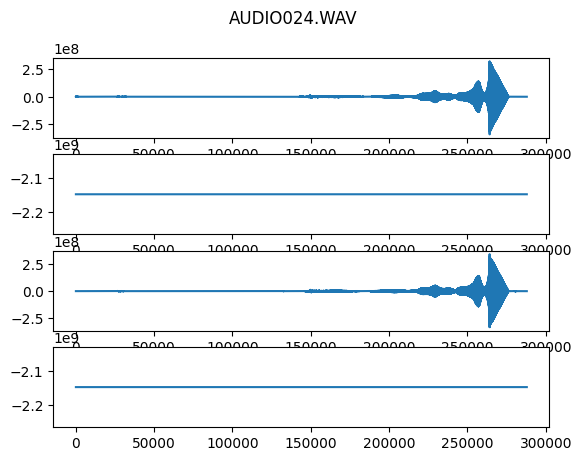

In [13]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(wav_props['num_channels'])
fig.suptitle(file_to_download)
for chanIdx in range(wav_props['num_channels']):
    axs[chanIdx].plot(wavF32[:,chanIdx])

### Write file to local disk

In [14]:
import tkinter as tk
from tkinter import filedialog
from pathlib import Path

root = tk.Tk()
root.withdraw()

if not(err):
    if not ("file_path" in locals() ):
        file_path = Path(filedialog.askdirectory())

    with open(file_path/file_to_download, "wb") as file:
        file.write(wav_bin)
        print("Wav file written:", file_path/file_to_download)


Wav file written: C:\Users\eyuan\Downloads\AUDIO024.WAV


### Read WAV file back into Python

In [15]:
import wave
import numpy as np

with wave.open(str(file_path/file_to_download), 'rb') as f:
    print("Reading WAV file back in: ", file_to_download)
    print("Sample Rate (hz): ", f.getframerate())
    print("Channels: ", f.getnchannels())
    wav_rate_hz = f.getframerate()
    wav_num_channels = f.getnchannels()

    # Read the whole file into a buffer. If you are dealing with a large file
    # then you should read it in blocks and process them separately.
    buffer = f.readframes(f.getnframes())
    # Convert the buffer to a numpy array by checking the size of the sample
    # width in bytes. The output will be a 1D array with interleaved channels.
    interleaved = np.frombuffer(buffer, dtype=f'int{f.getsampwidth()*8}')
    # Reshape it into a 2D array separating the channels in columns.
    wav_data = np.reshape(interleaved, (-1, f.getnchannels()))

Reading WAV file back in:  AUDIO024.WAV
Sample Rate (hz):  96000
Channels:  4


### Plot Local Wav File

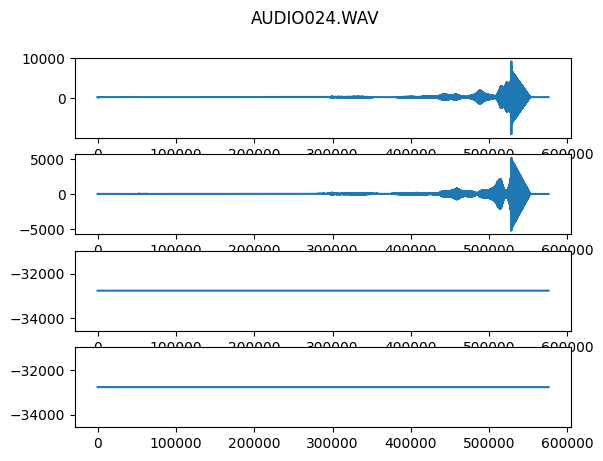

In [16]:
fig, axs = plt.subplots(wav_num_channels)
fig.suptitle(file_to_download)
for chanIdx in range(wav_num_channels):
    axs[chanIdx].plot(wav_data[:,chanIdx])

### Play audio

In [18]:
import pygame
pygame.mixer.init()
pygame.mixer.music.load(file_path/file_to_download)
pygame.mixer.music.play()
while pygame.mixer.music.get_busy():
    pass

In [ ]:
# Close Serial Port
tympan_port.close()